# EDA & Feature Engineering
***
Having cleaned data of the no-shows at doctor's appointments, we'll perform an EDA on this dataset to improve our understanding. As we aim to build a model to predict no-shows, we'll keep this brief and dedicate this partly to feature engineering.

**The ultimate goal is to understand if a user is coming to visit, given available data.**

In [1]:
import numpy as np
import pandas as pd
import tables

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

## 1. Import data
***

In [2]:
df = pd.read_hdf('data/no_shows_clean.h5', key='no_shows')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   patient_id       110526 non-null  object        
 1   appointment_id   110526 non-null  int64         
 2   gender           110526 non-null  object        
 3   scheduled_day    110526 non-null  datetime64[ns]
 4   appointment_day  110526 non-null  datetime64[ns]
 5   age              110526 non-null  int64         
 6   neighbourhood    110526 non-null  object        
 7   scholarship      110526 non-null  int64         
 8   hipertension     110526 non-null  int64         
 9   diabetes         110526 non-null  int64         
 10  alcoholism       110526 non-null  int64         
 11  handicap         110526 non-null  category      
 12  sms_received     110526 non-null  int64         
 13  no_show          110526 non-null  object        
 14  handicap_bin     110

In [3]:
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handicap,sms_received,no_show,handicap_bin
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


#### Set palette

In [4]:
sc = {'red': '#bf4040',
      'dark_grey': '#404040',
      'mid_grey' : '#807f80',
      'light_grey':'#bfbfbf',
      'blue' : '#5ac0fa'}

In [5]:
sns.set_palette(['#bf4040','#404040','#5ac0fa'])

## 2. Demographics
What do the demographic groups look like?

#### 2.1 feature engineering
Quickly make binary columns for `no_show` and `gender` (dummy variables)

In [6]:
# binary column no-shows
df['no_show_bin'] = df['no_show'].replace({'No':0, 'Yes':1})
df[['no_show','no_show_bin']].head()

,no_show,no_show_bin
0,No,0
1,No,0
2,No,0
3,No,0
4,No,0


In [7]:
# female-column
df['female'] = (df['gender'] == 'F')*1
df[['gender','female']].head()

,gender,female
0,F,1
1,M,0
2,F,1
3,F,1
4,F,1


#### 2.2 group size (binary metrics)

In [8]:
bin_cols = ['female','scholarship','hipertension','diabetes','alcoholism','sms_received','handicap_bin','no_show_bin']

In [9]:
df[bin_cols].sum()

female          71839
scholarship     10861
hipertension    21801
diabetes         7943
alcoholism       3360
sms_received    35482
handicap_bin     2241
no_show_bin     22319
dtype: int64

In [10]:
df[bin_cols].sum()*100/len(df)

female          64.997376
scholarship      9.826647
hipertension    19.724771
diabetes         7.186544
alcoholism       3.040009
sms_received    32.102854
handicap_bin     2.027577
no_show_bin     20.193439
dtype: float64

> Already, we can get some interesting insights from this data:
> * handicaps, alcoholism, handicap and scholarschip (~insurance) are rare groups (<10%)
> * no show is imbalanced, 20% of visits are no-shows (note: this is not imbalanced enough to have to act for ML)
> * we see more females than males (64% visits are by females)

#### 2.3 no-show across groups

In [11]:
group_split_1 = []
group_split_2 = []
cols = []

for col in bin_cols:
    if col!= 'no_show_bin':
        group_split_1.append(df.groupby(col)['no_show_bin'].mean()) #no-show perc per group
        group_split_2.append(df.groupby(col).size()) #size per group
        cols.append(col)

In [12]:
pd.concat([pd.DataFrame(group_split_1, index = cols),
           pd.DataFrame(group_split_2, index = cols)], axis = 1)

,0,1,0,1
female,0.199679,0.203149,38687,71839
scholarship,0.198074,0.237363,99665,10861
hipertension,0.209039,0.173020,88725,21801
diabetes,0.203630,0.180033,102583,7943
alcoholism,0.201948,0.201488,107166,3360
sms_received,0.167035,0.275745,75044,35482
handicap_bin,0.202355,0.181615,108285,2241


> we do not see any major effects, for most groups the no-show percentage varies between 19 and 23 percent. Exception is when a user received an sms. For visits where the user received an SMS, the no-show percentage is 27.5%, whereas it is 16.7% is the user did not receive an SMS. Do note that only 35,000 of 110.000 users received an SMS! (not neccesarily at random).

#### 2.4 age
We'll asses the age-gender composition of our dataset, and the no-show percentages.

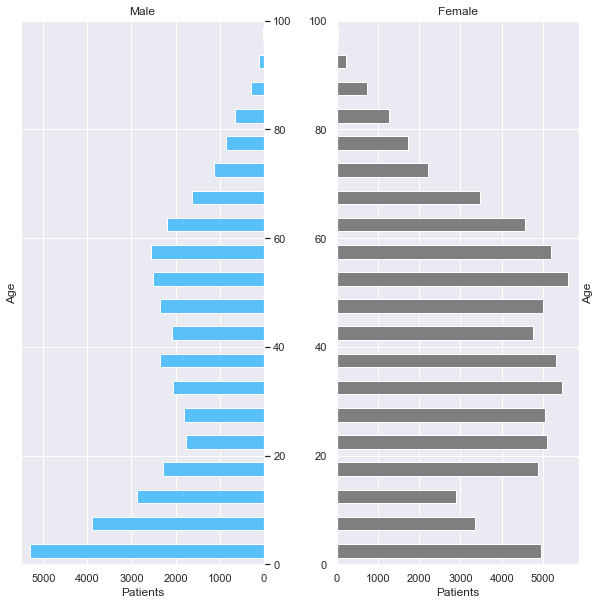

In [13]:
fig = plt.figure(figsize=(10,10))

# plot the histograme for "Male" on the left side.
# we need to have a vertical histogram with inverted x-axis and no labels
# the binsize is set by us at groups of 5 between 0 and 115
ax1 = fig.add_subplot(121)

# Male histogram
df[df['gender']=='M'].hist(column='age',bins=[i for i in range(0,116,5)], 
                           rwidth=0.5, orientation="horizontal", ax=ax1,
                           color=sc['blue'])#, alpha=0.6)

# Invert x-axis (count) and add labels
ax1.set_xlim(5500,0)
ax1.set_ylim(0,100)
ax1.set_title('Male')
ax1.set_xlabel('Patients')
ax1.yaxis.tick_right()
ax1.set_ylabel('Age')


# plot the vertical histogram for "Female" on the right side.
ax2 = fig.add_subplot(122)
df[df['gender']=='F'].hist(column='age',bins=[i for i in range(0,116,5)], 
                           rwidth=0.5, orientation="horizontal", ax=ax2,
                           color=sc['mid_grey'])#, alpha=0.6)
ax2.set_ylim(0,100)
ax2.set_title('Female')
ax2.set_xlabel('Patients')
ax2.set_ylabel('Age')
ax2.yaxis.set_label_position("right");

> More females than males (as seen before), but note the relative peak for young males (children).

In [14]:
# create age-bins
bin_edges = [i for i in range(0,116,5)]
bin_names = bin_edges[1:] #[i+5 for i in bin_edges[:-1]]
assert len(bin_names)==len(bin_edges)-1

In [15]:
# assign visits to an age-bin
df['age_group'] = pd.cut(df['age'], bin_edges, labels=bin_names)
df[['age','age_group']].head()

,age,age_group
0,62,65
1,56,60
2,62,65
3,8,10
4,56,60


In [16]:
no_show_bins = df.groupby(['age_group','gender'], as_index = False)['no_show_bin'].mean()
no_show_bins.head()

,age_group,gender,no_show_bin
0,5,F,0.190574
1,5,M,0.187050
2,10,F,0.221472
3,10,M,0.234433
4,15,F,0.261782


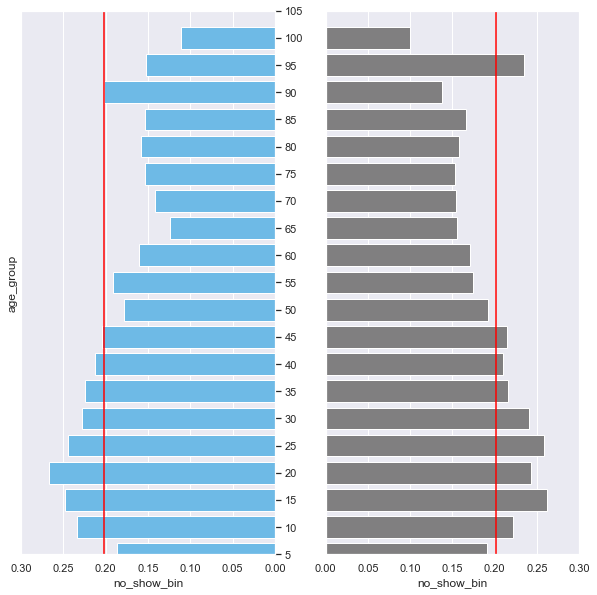

In [17]:
fig = plt.figure(figsize=(10,10))

# plot the now-show percentage for Males in each each age-group
ax1 = fig.add_subplot(121)
sns.barplot(x='no_show_bin', y='age_group', ax=ax1, 
            data = no_show_bins[no_show_bins['gender'] == 'M'], color=sc['blue'])

# plot a line for the overall no-show percentage
plt.axvline(df['no_show_bin'].mean(), color='red')
# adjust ticks and limits for the population pyramid
ax1.yaxis.tick_right()
ax1.set_xlim(.30,0)
ax1.set_ylim(0,20)

# plot the now-show percentage for Females in each each age-group
ax2 = fig.add_subplot(122)
sns.barplot(x='no_show_bin', y='age_group', 
            data = no_show_bins[no_show_bins['gender'] == 'F'], color=sc['mid_grey'])
# plot a line for the overall no-show percentage
plt.axvline(df['no_show_bin'].mean(), color='red')
# adjust ticks and limits for the population pyramid
ax2.set_xlim(0,.30)
ax2.set_ylabel("")
ax2.yaxis.set_ticks([])
ax2.set_ylim(0,20);

> The red-lines in the graph above denote the overall no-show percentage. We see that for both males and females, younger groups (<40) are more likely to no-show compared to elderly.

#### 2.5 suburb

In [18]:
suburbs = df.groupby('neighbourhood')['no_show_bin'].agg(['mean','size']).reset_index()
suburbs.sort_values('size', ascending = False)

,neighbourhood,mean,size
38,JARDIM CAMBURI,0.189841,7717
43,MARIA ORTIZ,0.209991,5805
59,RESISTÊNCIA,0.204469,4431
39,JARDIM DA PENHA,0.162755,3877
36,ITARARÉ,0.262664,3514
...,...,...,...
31,ILHA DO BOI,0.085714,35
32,ILHA DO FRADE,0.200000,10
0,AEROPORTO,0.125000,8
34,ILHAS OCEÂNICAS DE TRINDADE,1.000000,2


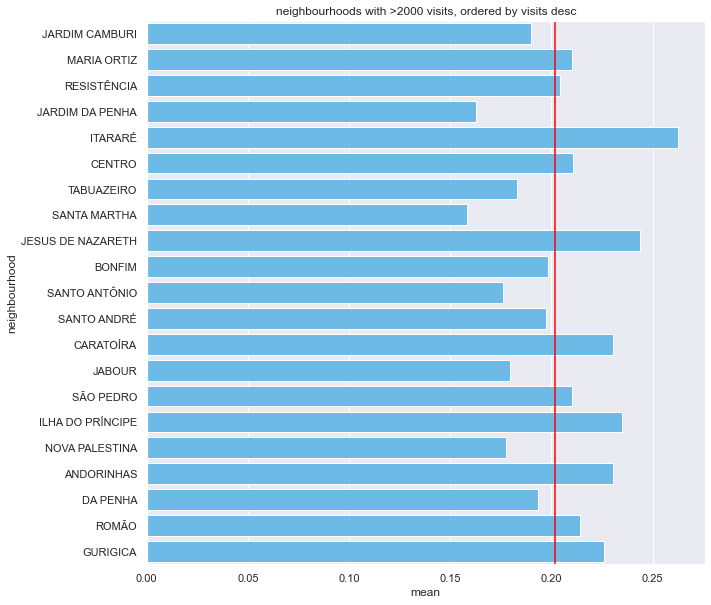

In [19]:
plt.figure(figsize = (10,10))
subs = suburbs[suburbs['size']>2000].sort_values('size', ascending = False).reset_index(drop=True)
sns.barplot(x = 'mean', y = 'neighbourhood', data = subs, color=sc['blue'])
plt.axvline(df['no_show_bin'].mean(), color='red')
plt.title('neighbourhoods with >2000 visits, ordered by visits desc');

> There is a bit of variation between visits in these suburbs, but it doesn't seem substantial. 

#### 2.6 brief summary so far
In terms of demographics, we mainly see an influence from SMS's (inverse of expected) and age. The other parameters don't seem to have a major influence 

## 3. Temporal
***
Can we distinguish patterns of no-show over time? 

We are breaking down the scheduled date and appointment date into their temporal components (day, month, ..), and look at no-show-rates across these slices. For a better picture, we also track the overall visits across these slices to better assess impact and filter outliers.

#### 3.1 feature engineering
Let's breakdown the time metrics available into it's components (as many as possible).

In [20]:
df[['scheduled_day','appointment_day']].head(2)

,scheduled_day,appointment_day
0,2016-04-29 18:38:08,2016-04-29
1,2016-04-29 16:08:27,2016-04-29


In [21]:
# order of days for use in categorical plot.
# chosen to keep saturday and sunday next to eachother to have weekend stand out
day_order = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
weekend_days = ['saturday', 'sunday']

# temporal features
df['scheduled_month'] = pd.to_datetime(df['scheduled_day']).dt.month
df['scheduled_week'] = pd.to_datetime(df['scheduled_day']).dt.week
df['scheduled_dom'] = pd.to_datetime(df['scheduled_day']).dt.day
df['scheduled_dow'] = pd.Categorical(pd.to_datetime(df['scheduled_day']).dt.day_name().str.lower(), ordered = True, categories = day_order)
df['scheduled_hour'] = pd.to_datetime(df['scheduled_day']).dt.hour
df['scheduled_day_type'] = df['scheduled_dow'].isin(weekend_days).replace({True : 'weekend', False : 'weekday'})


# day, month, dow, hour
# temporal features
df['appointment_month'] = pd.to_datetime(df['appointment_day']).dt.month
df['appointment_week'] = pd.to_datetime(df['appointment_day']).dt.week
df['appointment_dom'] = pd.to_datetime(df['appointment_day']).dt.day
df['appointment_dow'] = pd.Categorical(pd.to_datetime(df['appointment_day']).dt.day_name().str.lower(), ordered = True, categories = day_order)
#df['appointment_hour'] = pd.to_datetime(df['appointment_day']).dt.hour
df['appointment_day_type'] = df['appointment_dow'].isin(weekend_days).replace({True : 'weekend', False : 'weekday'})

# get the wait-time for the appointment in days
df['wait_time'] = (df['appointment_day'] - df['scheduled_day'])/np.timedelta64(1, 'D')
df['wait_time'] = ((df['wait_time'] >= 0)*df['wait_time']).astype(int) # negative values to zero

df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,...,scheduled_dom,scheduled_dow,scheduled_hour,scheduled_day_type,appointment_month,appointment_week,appointment_dom,appointment_dow,appointment_day_type,wait_time
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,29,friday,18,weekday,4,17,29,friday,weekday,0
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,29,friday,16,weekday,4,17,29,friday,weekday,0
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,...,29,friday,16,weekday,4,17,29,friday,weekday,0
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,29,friday,17,weekday,4,17,29,friday,weekday,0
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,29,friday,16,weekday,4,17,29,friday,weekday,0


#### 3.2 per month

In [22]:
# plotting functions we can use for all temporal elements
def perc_plot(ax, df, date_part, col = '#9999FF'):
    tmp = df.groupby(date_part, as_index=False)['no_show_bin'].mean()
    sns.barplot(ax = ax, data = tmp, x = date_part, y = 'no_show_bin', color = col)
    ax.axhline(df['no_show_bin'].mean(), color='red')
    
def temp_plot(df, date_part):
    fig, ax = plt.subplots(2,2, figsize=(15,8)) #row,col
    
    sns.countplot(ax = ax[0][0], data = df, x = 'scheduled_'+date_part, color = sc['mid_grey'])
    sns.countplot(ax = ax[0][1], data = df, x = 'appointment_'+date_part, color = sc['blue'])
    
    perc_plot(ax[1][0], df, 'scheduled_'+date_part, sc['mid_grey'])
    perc_plot(ax[1][1], df, 'appointment_'+date_part, sc['blue'])

In [23]:
df[['scheduled_day','appointment_day']].agg(['min','max'])

,scheduled_day,appointment_day
min,2015-11-10 07:13:56,2016-04-29
max,2016-06-08 20:07:23,2016-06-08


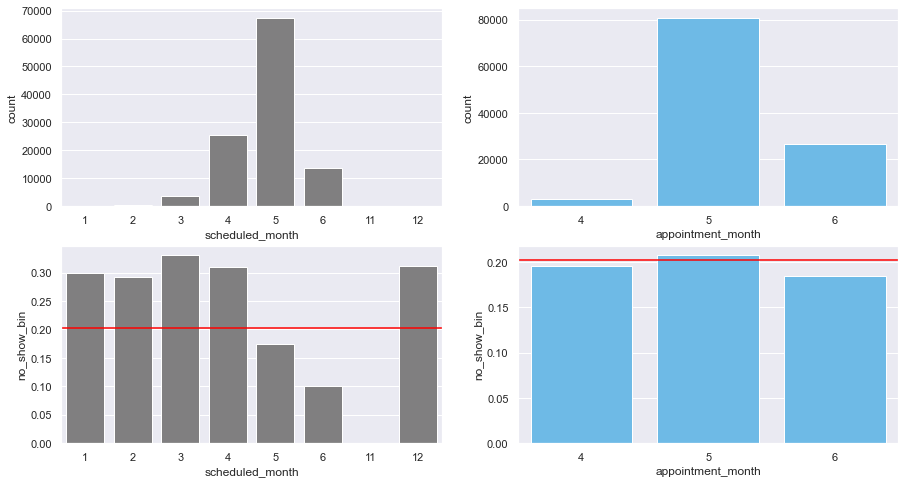

In [24]:
temp_plot(df, 'month')

> Users that schedule their appointment before May (month=5), have a higher probability of not showing up than users in May and June (here, we see an below-average no-show rate). One hypothesis for this is that the wait-time, between scheduling the appointment and the appointment itself affects the no-show rate.

> The month of the appointment doesn't have a massive influence.

> note: month 12 is December 2015 (last year).

#### 3.3 per week

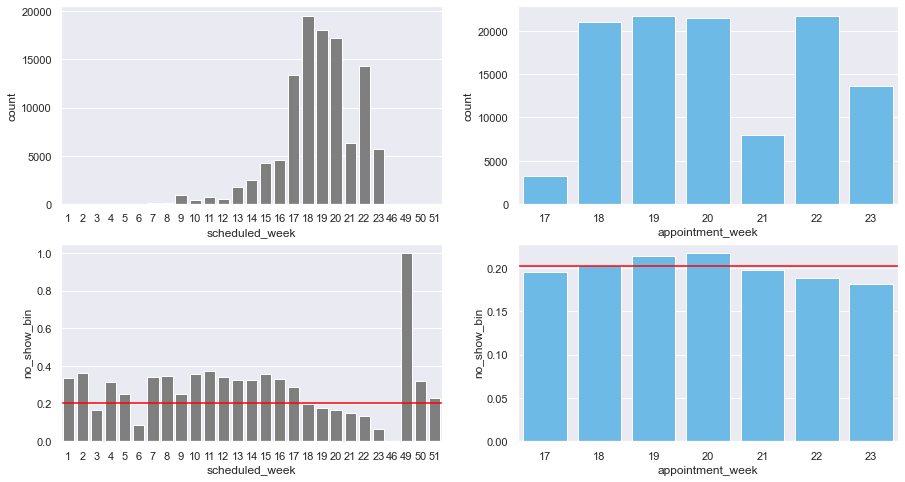

In [25]:
temp_plot(df, 'week')

> weekly breakdown shows the same pattern observed for months:
> * the week of the appointment doesn't affect the no-show rate much
> * the scheduled-week does impact the no-show rate; months in May (where appointments are) show lower no-show rates.

#### 3.4 per day-of-month

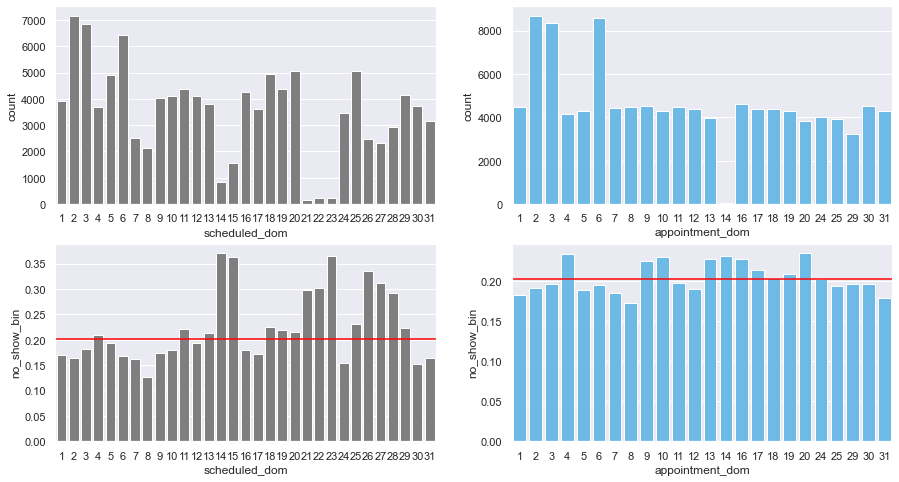

In [26]:
temp_plot(df, 'dom')

> The day of the month does not seem to influence the no-show rate. The dominant peaks in scheduled day correlate with low nr of scheduled visits on those days, which could be weekends.

#### 3.5 per day-of-week

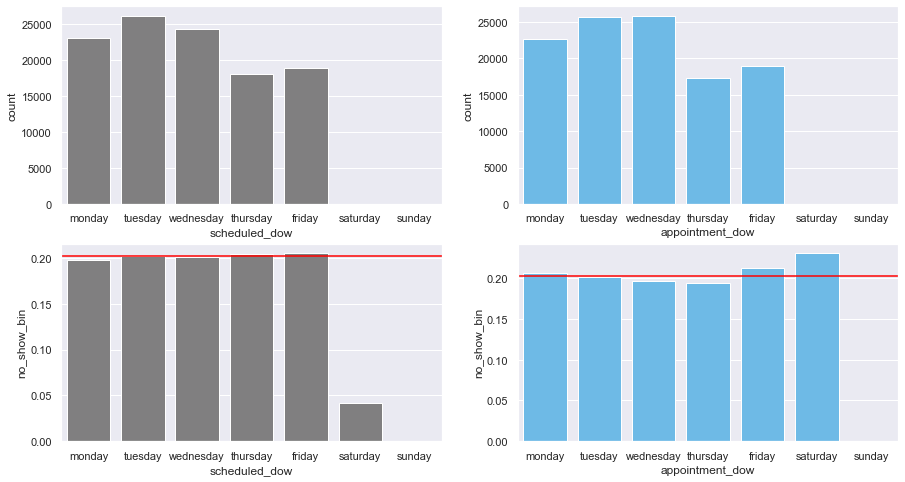

In [27]:
temp_plot(df, 'dow')

> Minimal differences in no-show rate for day of week. Visits scheduled on Saturday have a lower no-show rate, whilst the actual visits (appointments) on Saturday have a slightly higher no-show rate. But the general number of visits on Saturday are low, hence the low impact.

> There is no hour available for the appointments. For the scheduled_hour, there seems to be little impact.

#### 3.6 per day-type

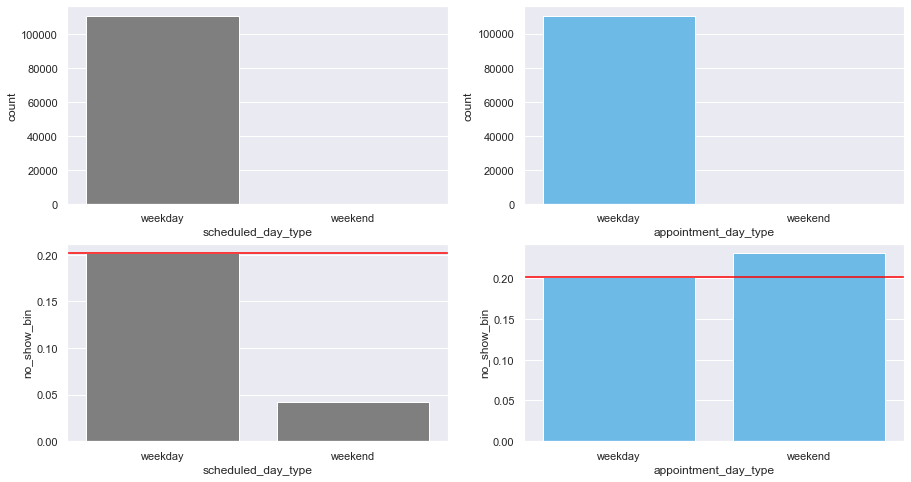

In [28]:
temp_plot(df, 'day_type')

> Looking at weekend vs. weekday, we see the same pattern we saw from day-of-week. 

#### 3.7 wait-time
Earlier on, we formuated the hypothesis that the wait-time between scheduling and appointment and the actial appointment might have a big impact, so lets verify this!

In [29]:
# calculate 'no-show rate' per wait-time in days
# only when we have >100 visits
waits = df.groupby('wait_time')['no_show_bin'].agg(['mean','size']).reset_index()
waits = waits[waits['size'] > 100]
waits.head()

,wait_time,mean,size
0,0,0.066469,43780
1,1,0.238216,6725
2,2,0.235294,2737
3,3,0.232703,5290
4,4,0.266097,3277


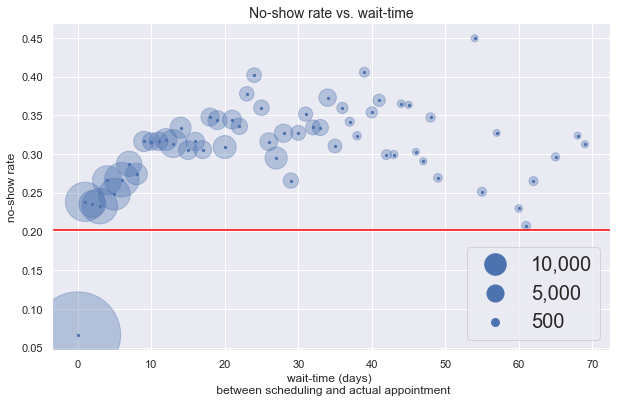

In [30]:
# use a scaled version of 'group size' as markersize
plt.figure(figsize = (10,6))
plt.scatter(data = waits, x = 'wait_time', y = 'mean', s = np.power(waits['size'],5/6), c='b', alpha=0.35)
plt.scatter(data = waits, x = 'wait_time', y = 'mean', s = 5, c='b', alpha=1)
plt.axhline(df['no_show_bin'].mean(), color='red')

gll = plt.scatter([],[], s=np.power(10000,2/3), marker='o', color='b')
gl = plt.scatter([],[], s=np.power(5000,2/3), marker='o', color='b')
ga = plt.scatter([],[], s=np.power(500,2/3), marker='o', color='b')

plt.legend((gll,gl,ga),
       ('10,000', '5,000', '500'),
       scatterpoints=1,
       loc='lower right',
       ncol=1,
       fontsize=8,
       prop={'size': 20})

plt.ylabel('no-show rate', fontsize = 12)
plt.xlabel('wait-time (days) \n between scheduling and actual appointment', fontsize = 12)
plt.title('No-show rate vs. wait-time', fontsize = 14)
plt.savefig('screenshot.png');

> So far this indeed seems to be a winner! No wait-time (i.e. appointment on the same day as it is scheduled), sees a no-show rate of only 6.6%, observed fro 43,780 visits; substantially lower than the average of 20%. 

> In addition, we see that the no-show rate increases with wait-time; if the wait-time is >10 days, we see no-show percentages of > 30%!

#### 3.8 wait-time & SMS
Earlier on we've seen the counter-intuitive result that user who've received a reminder SMS got a higher no-show rate compared to users who've received no reminder sms. One hypothesis is that users with a low-wait time (same-day appointment) are not send a reminder. 

In [31]:
df.groupby('wait_time')['sms_received'].sum().head()

wait_time
0       0
1       0
2     906
3    3054
4    2054
Name: sms_received, dtype: int64

> our hunch was right! Users only seem to get a reminder sms when the wait-time is more than 1 day. If we filter on that, does the SMS seem to have a positive effect on no-show-rate?

In [32]:
df[df['wait_time']>1].groupby('sms_received')['no_show_bin'].mean()

sms_received
0    0.326949
1    0.275745
Name: no_show_bin, dtype: float64

> Yest it does! Getting a reminder SMS drop the no-show rate from 32.6% to 27.5%; a substantial improvement.

## 4. Behavioral (RFM)
***
So far, we've looked at temporal patterns and demographic patterns. We do however have a unique patient-id and repear visits, so we can also include some behavioral patterns! Often, we start here with RFM (Recency, Frequency and Value) as inspiration and look for similar metrics we can build from the available data.

As temporal windows would apply, window functions would be our friend in SQL. To switch to Pandas equivalents: https://towardsdatascience.com/sql-window-functions-in-python-pandas-data-science-dc7c7a63cbb4

Relating back to our goal *(.. understand if a patient is coming to his appointment, given available data)*, we note that the implication of this is that for a given user, with an appoint at time T, we can only use historic data uptill this time T.

#### 4.1 repeat visits

In [33]:
print(len(df))
df['patient_id'].nunique()

110526


62298

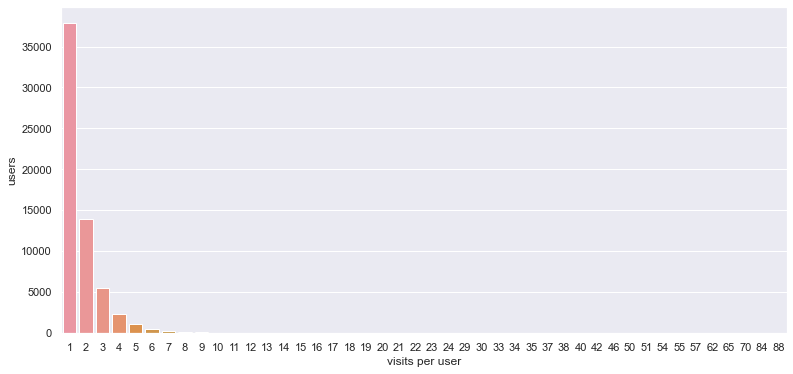

In [34]:
plt.figure(figsize=(13,6))
sns.countplot(df['patient_id'].value_counts()) #how often doe patients come to visit!?
plt.xlabel('visits per user')
plt.ylabel('users');

> We have 110,526 recorded appointments, for 62,298 patients; on average we have ~two visits per user! Worth making some features for this.

#### 4.2 duplicate appointments - identification

In [35]:
# appointment_id has strictly unique identifiers
df.appointment_id.nunique()

110526

In [36]:
# patient + appointsment does have duplicates...
df[['patient_id','appointment_day']].duplicated().sum()

8719

In [37]:
df[df[['patient_id','appointment_day']].duplicated()].head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,...,scheduled_dom,scheduled_dow,scheduled_hour,scheduled_day_type,appointment_month,appointment_week,appointment_dom,appointment_dow,appointment_day_type,wait_time
27,12154843752835,5628345,F,2016-04-27 10:51:45,2016-04-29,4,CONQUISTA,0,0,0,...,27,wednesday,10,weekday,4,17,29,friday,weekday,1
154,19252634865,5636933,F,2016-04-28 16:38:34,2016-04-29,30,ITARARÉ,0,0,0,...,28,thursday,16,weekday,4,17,29,friday,weekday,0
288,22462135793684,5532908,M,2016-03-31 12:39:06,2016-04-29,43,CARATOÍRA,0,0,0,...,31,thursday,12,weekday,4,17,29,friday,weekday,28
290,7222383233748,5566070,M,2016-04-11 09:50:18,2016-04-29,7,CARATOÍRA,0,0,0,...,11,monday,9,weekday,4,17,29,friday,weekday,17
316,17565785761493,5582867,F,2016-04-14 10:01:09,2016-04-29,1,JOANA D´ARC,0,0,0,...,14,thursday,10,weekday,4,17,29,friday,weekday,14


In [38]:
# check out a specific case
df[df['patient_id'] == '1115255573477']

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,...,scheduled_dom,scheduled_dow,scheduled_hour,scheduled_day_type,appointment_month,appointment_week,appointment_dom,appointment_dow,appointment_day_type,wait_time
31226,1115255573477,5637950,M,2016-04-29 07:33:32,2016-05-03,60,CENTRO,0,0,0,...,29,friday,7,weekday,5,18,3,tuesday,weekday,3
31231,1115255573477,5637954,M,2016-04-29 07:33:43,2016-05-03,60,CENTRO,0,0,0,...,29,friday,7,weekday,5,18,3,tuesday,weekday,3
101631,1115255573477,5721667,M,2016-05-19 17:24:01,2016-06-01,60,CENTRO,0,0,0,...,19,thursday,17,weekday,6,22,1,wednesday,weekday,12
101635,1115255573477,5721666,M,2016-05-19 17:24:01,2016-06-01,60,CENTRO,0,0,0,...,19,thursday,17,weekday,6,22,1,wednesday,weekday,12


> We can see two variation on duplicate `patient_id` + `appointment_day` here:
> * different `scheduled_day` (often short period apart). This could hint towards i.e. creating a new appointment when changing details, or separate appointments if they visit two specialist at the clininc.
> * also the same `scheduled_day`. This could be a logging issue (double recording with aut_increment in appointment_id) OR again two appointments with various specialist on the same day (note that appointment_day only has a 'date' granularity.

> As we don't know the background behind this, we will try to annotate it for further analysis/user in the modeling. We will need to keep this in mind when we look at lags between a user's appointments.

In [39]:
# how often dow we see full duplicates!?
df[['patient_id','appointment_day','scheduled_day']].duplicated().sum()

1334

#### 4.3 duplicate appointments - annotation

In [40]:
# get all dupplicates
dupes = df[df[['patient_id','appointment_day']].duplicated(keep = False)][['patient_id','appointment_day','scheduled_day','appointment_id', 'no_show_bin']]

# add a parameter denoting the duplication
dupes['duplicate'] = 1

# find the first case and annotate
# by scheduled_day, or appointment_id if duplicated
dupes['duplicate_first'] = dupes.sort_values(['scheduled_day','appointment_id'])\
                                     .groupby(['patient_id','appointment_day'])\
                                     .cumcount() + 1
dupes['duplicate_first'] = (dupes['duplicate_first'] == 1)*1

# find the last case and annotate
# by scheduled_day, or appointment_id is duplicated
dupes['duplicate_last'] = dupes.sort_values(['scheduled_day','appointment_id'], ascending = False)\
                                     .groupby(['patient_id','appointment_day'])\
                                     .cumcount() + 1
dupes['duplicate_last'] = (dupes['duplicate_last'] == 1)*1

dupes.sort_values('patient_id').head(10)

,patient_id,appointment_day,scheduled_day,appointment_id,no_show_bin,duplicate,duplicate_first,duplicate_last
103284,111415561531417,2016-06-06,2016-05-19 16:13:52,5721379,1,1,0,1
105563,111415561531417,2016-06-06,2016-05-04 10:02:43,5657853,1,1,1,0
31231,1115255573477,2016-05-03,2016-04-29 07:33:43,5637954,0,1,0,1
31226,1115255573477,2016-05-03,2016-04-29 07:33:32,5637950,0,1,1,0
101635,1115255573477,2016-06-01,2016-05-19 17:24:01,5721666,0,1,1,0
101631,1115255573477,2016-06-01,2016-05-19 17:24:01,5721667,0,1,0,1
88388,11163631268489,2016-06-07,2016-05-24 14:37:56,5733888,0,1,0,1
109197,11163631268489,2016-06-07,2016-05-19 10:30:51,5719053,0,1,1,0
9085,11172734231776,2016-05-03,2016-05-03 07:24:53,5650036,0,1,1,0
9033,11172734231776,2016-05-03,2016-05-03 07:36:37,5650298,0,1,0,1


In [41]:
dupes.groupby('duplicate_last')['no_show_bin'].mean()

duplicate_last
0    0.260580
1    0.173907
Name: no_show_bin, dtype: float64

In [42]:
# add full duplicates
full_dupes = dupes[dupes[['patient_id','appointment_day','scheduled_day']].duplicated(keep=False)].reset_index(drop=True)
full_dupes['full_duplicate'] = 1
print(len(full_dupes))
full_dupes.groupby('duplicate_last')['no_show_bin'].mean()

2609


duplicate_last
0    0.341826
1    0.338629
Name: no_show_bin, dtype: float64

> duplicates do have an effect on no-show rate. In general we, see the no-show rate for the last scheduled appointment is lower than the first, supporting the hypothesis that some 'changes' or 'updates' are made to an appointment and logged with a new appointment_id

> for full duplicates (also same scheduled_time), we see a very high no-show rate of ~34%.

> let's bring this into the main dataframe (SQL: left join & coalesce)

In [43]:
# merge full_dupes and dupes
dupes2 = dupes.merge(full_dupes[['patient_id','appointment_id','appointment_day','scheduled_day','full_duplicate']],
                     on = 'appointment_id', how = 'left').fillna(0)

dupes2[dupes2['full_duplicate'] == 0].groupby('duplicate_last')['no_show_bin'].mean()

duplicate_last
0    0.244867
1    0.142562
Name: no_show_bin, dtype: float64

In [44]:
dupes2.head()

,patient_id_x,appointment_day_x,scheduled_day_x,appointment_id,no_show_bin,duplicate,duplicate_first,duplicate_last,patient_id_y,appointment_day_y,scheduled_day_y,full_duplicate
0,29872499824296,2016-04-29,2016-04-29 18:38:08,5642903,0,1,0,1,0,0,0,0.0
1,558997776694438,2016-04-29,2016-04-29 16:08:27,5642503,0,1,0,1,0,0,0,0.0
2,4262962299951,2016-04-29,2016-04-29 16:19:04,5642549,0,1,0,1,0,0,0,0.0
3,12154843752835,2016-04-29,2016-04-27 10:50:45,5628338,1,1,1,0,0,0,0,0.0
4,12154843752835,2016-04-29,2016-04-27 10:51:45,5628345,0,1,0,1,0,0,0,0.0


In [45]:
# add our new parameters to the full group
df = df.merge(dupes2[['appointment_id','duplicate','duplicate_first','duplicate_last','full_duplicate']],
              on = 'appointment_id', how = 'left')
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,...,appointment_month,appointment_week,appointment_dom,appointment_dow,appointment_day_type,wait_time,duplicate,duplicate_first,duplicate_last,full_duplicate
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,4,17,29,friday,weekday,0,1.0,0.0,1.0,0.0
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,4,17,29,friday,weekday,0,1.0,0.0,1.0,0.0
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,...,4,17,29,friday,weekday,0,1.0,0.0,1.0,0.0
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,4,17,29,friday,weekday,0,NaN,NaN,NaN,NaN
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,4,17,29,friday,weekday,0,NaN,NaN,NaN,NaN


In [46]:
df['duplicate'].fillna(0, inplace=True)
df['duplicate_first'].fillna(0, inplace=True)
df['duplicate_last'].fillna(0, inplace=True)
df['full_duplicate'].fillna(0, inplace=True)
df.head()

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,...,appointment_month,appointment_week,appointment_dom,appointment_dow,appointment_day_type,wait_time,duplicate,duplicate_first,duplicate_last,full_duplicate
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,...,4,17,29,friday,weekday,0,1.0,0.0,1.0,0.0
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,...,4,17,29,friday,weekday,0,1.0,0.0,1.0,0.0
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,...,4,17,29,friday,weekday,0,1.0,0.0,1.0,0.0
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,...,4,17,29,friday,weekday,0,0.0,0.0,0.0,0.0
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,...,4,17,29,friday,weekday,0,0.0,0.0,0.0,0.0


#### 4.4 number of visits (F)
Number of visits as user has had. 

SQL: `ROW_NUMBER() OVER (PARTITION BY patient_id ORDER BY appointment_day)` 

We have generated parameters to deal with duplicates. 

In [47]:
df['num_visits'] = df.sort_values(['appointment_day','scheduled_day','appointment_id'], ascending=True)\
                     .groupby(['patient_id'])\
                     .cumcount() + 1

df.sort_values(['appointment_day','scheduled_day','appointment_id'])[['patient_id','appointment_day','num_visits']].tail()

,patient_id,appointment_day,num_visits
92442,729255235141745,2016-06-08,6
88146,947614361749238,2016-06-08,3
88147,356247857784,2016-06-08,2
87219,234131759175,2016-06-08,2
87223,5237164264312,2016-06-08,1


In [48]:
df.groupby('num_visits')['no_show_bin'].agg(['mean','count']).head()

,mean,count
num_visits,,
1,0.195287,62298
2,0.207720,24379
3,0.214327,10484
4,0.229334,4984
5,0.225067,2617


#### 4.5 no_show last visit (M)
SQL: `LAG(no_show_bin) OVER (PARTITION BY patient_id ORDER BY appointment_day)` + COALESCE

In [49]:
df['no_show_last_visit'] = df.sort_values(['appointment_day','scheduled_day','appointment_id'], ascending=True)\
                                          .groupby('patient_id')['no_show_bin'].shift(1).fillna(0)

df['no_show_last_visit'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: no_show_last_visit, dtype: float64

In [50]:
df.groupby('no_show_last_visit')['no_show_bin'].agg(['mean','count']).head()

,mean,count
no_show_last_visit,,
0.0,0.187744,100488
1.0,0.343993,10038


> We do have some noise here - `no_show_last_visit` also includes users that are 'visiting' for the first time. Let's adjust for that!

In [51]:
df[df['num_visits']>1].groupby('no_show_last_visit')['no_show_bin'].agg(['mean','count']).head()

,mean,count
no_show_last_visit,,
0.0,0.175439,38190
1.0,0.343993,10038


> this is very interesting: a now show last visit means a user is twice as likely to not show up for this appointment!

#### 4.6 time since last visit (R)
SQL: `LAG(appointment_day) OVER (PARTITION BY patient_id ORDER BY appointment_day)`

In [52]:
df['last_visit'] = df.sort_values(['appointment_day','scheduled_day','appointment_id'], ascending=True)\
                                          .groupby('patient_id')['appointment_day'].shift(1)

# recency in days
df['recency'] = (df['appointment_day'] - df['last_visit'])/np.timedelta64(1, 'D')
df['recency'].fillna(0, inplace=True)
df['recency'] = df['recency'].astype(int)
df.drop('last_visit', axis = 1, inplace=True)

df['recency'].tail()

110521    22
110522     4
110523     0
110524    33
110525    34
Name: recency, dtype: int64

In [53]:
df[df['num_visits']>1].groupby('recency')['no_show_bin'].agg(['mean','count']).head(10)

,mean,count
recency,,
0,0.177314,8719
1,0.180744,4487
2,0.193272,3151
3,0.211205,2249
4,0.216632,1948
5,0.216524,2457
6,0.222078,2310
7,0.255572,4038
8,0.220046,1736


> As expected, recency does not seem to make a massive difference. We do see that appointments following shortly after one-another have a lower no-show rate. Note that recency = 0 are the duplicates we've seen in 4.2 and 4.3

## 5. Closing thoughts
***

#### 5.1 store our dataframe with the added features

In [54]:
# quick check for missing data & remove temp column
df.drop('age_group', axis = 1, inplace = True)
df.isnull().sum().sum()

0

In [55]:
filename = 'data/no_shows_features.h5'
print(filename)

data/no_shows_features.h5


In [56]:
df.to_hdf(filename, key = 'aap', mode = 'w', format ='table')

In [57]:
df_check = pd.read_hdf(filename)
print(df_check.shape)
df.info()

(110526, 36)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110525
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   patient_id            110526 non-null  object        
 1   appointment_id        110526 non-null  int64         
 2   gender                110526 non-null  object        
 3   scheduled_day         110526 non-null  datetime64[ns]
 4   appointment_day       110526 non-null  datetime64[ns]
 5   age                   110526 non-null  int64         
 6   neighbourhood         110526 non-null  object        
 7   scholarship           110526 non-null  int64         
 8   hipertension          110526 non-null  int64         
 9   diabetes              110526 non-null  int64         
 10  alcoholism            110526 non-null  int64         
 11  handicap              110526 non-null  category      
 12  sms_received          110526 non-null  int64 

#### 5.2 outlook
Main insights from this EDA are that `wait_time` and `previous no-shows` strong indicators of a current no-show seem to be. Whether a reminder SMS was send, surprisingly enough, show

Other parameters show interesting patterns, but a less strong correlation with no_show than the above.

We haven't considere correlations between the parameters themselves in this analysis, whereas we know we've introduced some highly-correlating parameter with the features we've created (by design). In the modelling phase, we thus need a model that can deal with this, which most likely would be a random forrest.


#### 5.3 Closing note of RFM metrics
RFM metrics (section 4) are based a a users historic interactions, including i.e. number of visits.

As we only only have ~1 month of data, this will not use accurate statistics on a user. A user could be a frequent visitor on a montly basis (schedule recurrence for i.e. checkup), but we would still capture this user as 'new' with a '1 visit'.

Having additional data (months) could help here. Typically, to deal with this we address calculations per cohort (i.e. all users that have been registered with us since xxx).